In [1]:
import read_params
import numpy as np
import os
import fnmatch
from astropy.io import fits
from astropy.constants import R_sun
import matplotlib.pyplot  as plt
import modefilters
%matplotlib inline

In [2]:
ridge_filters = ["fmode_filter","p1mode_filter","p2mode_filter","p3mode_filter",
                 "p4mode_filter","p5mode_filter","p6mode_filter","p7mode_filter"]
datadir = read_params.get_directory()
Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
Rsun = R_sun.value
z = np.loadtxt(read_params.get_solarmodel(),usecols=[0]); z=(z-1)*Rsun

In [3]:
src = 1
src_loc = np.loadtxt(os.path.join(datadir,"master.pixels"),ndmin=1)[src-1]
with fits.open(os.path.join(datadir,"data","{:02d}.fits".format(src))) as hdu:
    data = hdu[0].data.squeeze()
nt = data.shape[0]
dt_sec = read_params.get_dt()
t = np.arange(nt)*dt_sec

## Plot filtered data

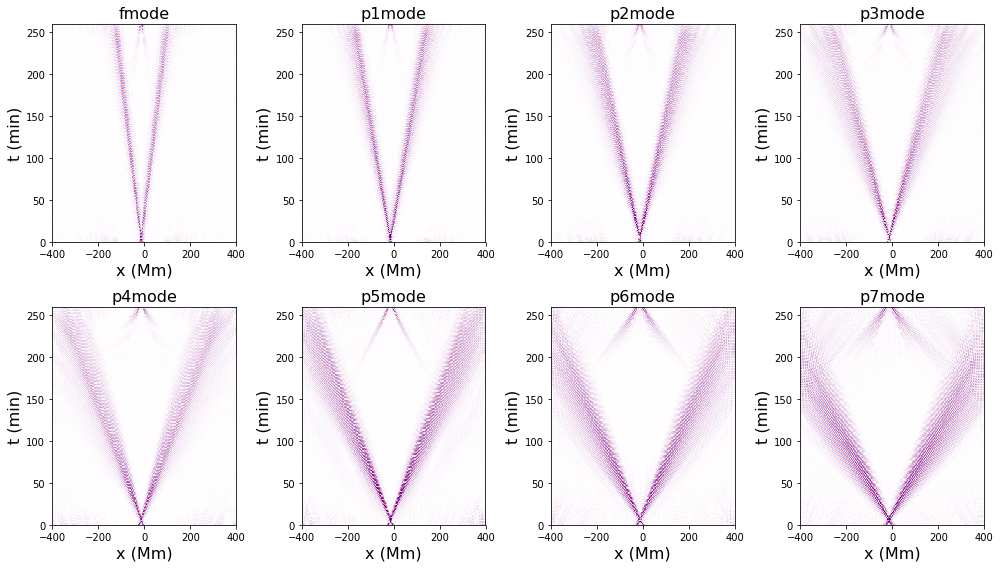

In [4]:
for ind,f in enumerate(ridge_filters):
    plt.subplot(2,4,ind+1)
    ridge_fn = getattr(modefilters,f)
    ridge = np.squeeze(ridge_fn(nt,dt_sec,nx,Lx)).T
    data_filtered = np.fft.ifft2(np.fft.fft2(data)*ridge).real
    vmax = abs(data_filtered).max()
    plt.pcolormesh(x,t/60,data_filtered,cmap="seismic",vmax=vmax,vmin=-vmax)
    plt.title(f.split("_")[0],fontsize=16)
    plt.xlabel("x (Mm)",fontsize=16)
    plt.ylabel("t (min)",fontsize=16)
    plt.xlim(x[0],x[-1])
    plt.ylim(t[0]/60,t[-1]/60)

plt.gcf().set_size_inches(14,8)
plt.tight_layout()

## Compute wave speed

In [5]:
def find_maxima(arr):
    return np.where(np.diff(np.sign(np.diff(arr)))==-2)[0]

def get_peak_loc_and_width(u):
    max_loc = abs(u).argmax()
    # find peaks around maximum

    window = 40
    low_t = max(max_loc-window,0)
    high_t = max_loc + window
    u_window = u[low_t:high_t]
    peak_locations = find_maxima(u_window)+1
    u_window_peaks = u_window[peak_locations]
    u_window_peaks = u_window_peaks[np.where(u_window_peaks>0)[0]]
    peak_locations = peak_locations[np.where(u_window_peaks>0)[0]]
    peaks = np.log(u_window_peaks)
    p = np.polyfit(peak_locations+low_t,peaks,2)
    
    t0 = -p[1]/(2*p[0])
    sigma = 1/np.sqrt(-2*p[0]) if p[0]<0 else -1
    # A = np.exp(p[2]+x0**2/(2*sigma**2))
    arrival = int(t0-2*sigma) if sigma >0 else -1
    departure = int(t0+2*sigma) if sigma>0 else -1
    return int(t0),int(sigma),arrival,departure

def get_wave_speed(data_ridge):
    x_fit_ind = np.array([abs(x-x_fit_i).argmin() for x_fit_i in np.arange(20,60,5)])
    t_fit_ind = np.array([get_peak_loc_and_width(data_ridge[:,ind])[0] for ind in x_fit_ind])
    # Make sure that array is in ascending order
    unclear_points = np.where(np.sign(np.diff(t_fit_ind))!=1)[0]
    # Remove fishy points
    x_fit_ind = np.delete(x_fit_ind,unclear_points)
    t_fit_ind = np.delete(t_fit_ind,unclear_points)
    m,_=np.polyfit(t[t_fit_ind]/60,x[x_fit_ind],1)
    return m

wave_speeds = []

for ind,f in enumerate(ridge_filters):
    ridge_fn = getattr(modefilters,f)
    ridge = np.squeeze(ridge_fn(nt,dt_sec,nx,Lx)).T
    data_filtered = np.fft.ifft2(np.fft.fft2(data)*ridge).real
    wave_speed = round(get_wave_speed(data_filtered),2)
    print(f.split("_")[0],"speed",wave_speed,"Mm/min")
    wave_speeds.append(wave_speed)

fmode speed 0.45 Mm/min
p1mode speed 0.65 Mm/min
p2mode speed 0.76 Mm/min
p3mode speed 1.0 Mm/min
p4mode speed 1.3 Mm/min
p5mode speed 1.39 Mm/min
p6mode speed 1.89 Mm/min
p7mode speed 2.14 Mm/min


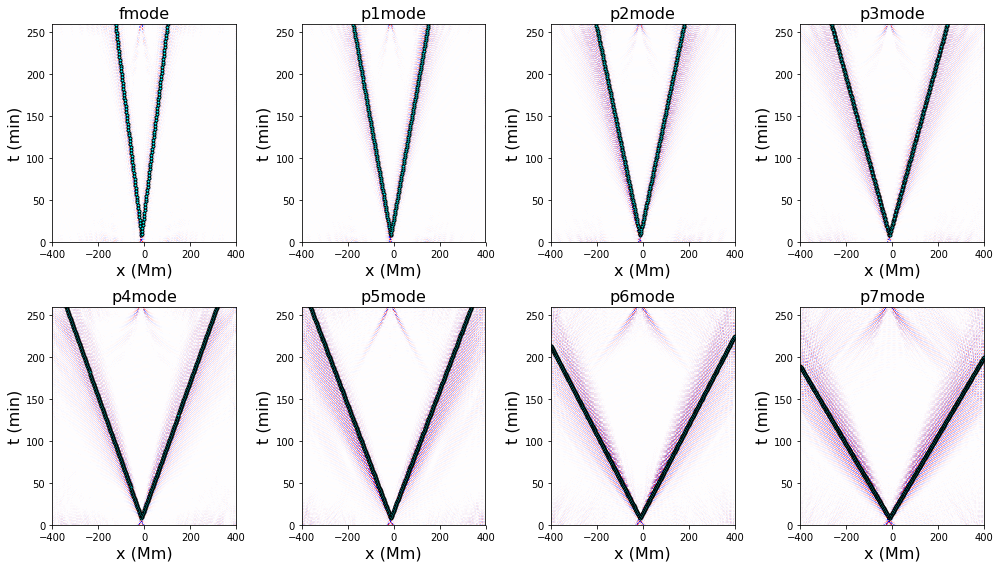

In [6]:
for ind,f in enumerate(ridge_filters):
    plt.subplot(2,4,ind+1)
    ridge_fn = getattr(modefilters,f)
    ridge = np.squeeze(ridge_fn(nt,dt_sec,nx,Lx)).T
    data_filtered = np.fft.ifft2(np.fft.fft2(data)*ridge).real
    vmax = abs(data_filtered).max()
    plt.pcolormesh(x,t/60,data_filtered,cmap="seismic",vmax=vmax,vmin=-vmax)
    plt.title(f.split("_")[0],fontsize=16)
    plt.xlabel("x (Mm)",fontsize=16)
    plt.ylabel("t (min)",fontsize=16)
    plt.xlim(x[0],x[-1])
    plt.ylim(t[0]/60,t[-1]/60)
    line = abs(x-src_loc)/wave_speeds[ind]+8
    plt.plot(x,line,ls="dashed",color="black",marker="o",markersize=3,markerfacecolor="cyan")

plt.gcf().set_size_inches(14,8)
plt.tight_layout()

## Params

In [7]:
params=[]
for ind,f in enumerate(ridge_filters): 
    x_at_final_time = (t[-1]/60-8)*wave_speeds[ind]+src_loc
    x_final_ind = int((x_at_final_time/Lx+0.5)*nx)
#     print(x_at_final_time,x_final_ind)
    # Get width at final time
    ridge_fn = getattr(modefilters,f)
    ridge = np.squeeze(ridge_fn(nt,dt_sec,nx,Lx)).T
    data_filtered = np.fft.ifft2(np.fft.fft2(data)*ridge).real
    
    if x_final_ind<nx-1:
        _,sigma,arrival,departure = get_peak_loc_and_width(data_filtered[:,x_final_ind-10])
        while departure>nt-10 or departure<0:
            x_final_ind -= 1
            x_at_final_time = x[x_final_ind]
            _,sigma,arrival,departure = get_peak_loc_and_width(data_filtered[:,x_final_ind])
            if sigma<0: continue
            if x_at_final_time<0: 
                print("Could not locate any end point")
                break
#     else:
#         halfway_x = (Lx/2+src_loc)/2
#         halfway_x_ind = int((halfway_x/Lx+0.5)*nx)
#         sigma_halfway = get_peak_loc_and_width(data_filtered[:,halfway_x_ind])[1]
#         sigma_Lxby2 = sigma_halfway*2 # approximately, assuming linear growth
#         x_at_final_time = Lx/2 - sigma_Lxby2*wave_speeds[ind]
        
    
    print(f.split("_")[0],"params",10,"to",x_at_final_time,"\twindow halftime",2*sigma)
    params.append((10,x_at_final_time))

fmode params 10 to 101.175 	window halftime 66
p1mode params 10 to 121.875 	window halftime 72
p2mode params 10 to 145.3125 	window halftime 94
p3mode params 10 to 189.0625 	window halftime 102
p4mode params 10 to 262.5 	window halftime 92
p5mode params 10 to 279.6875 	window halftime 96
p6mode params 10 to 463.335 	window halftime 96
p7mode params 10 to 526.21 	window halftime 96


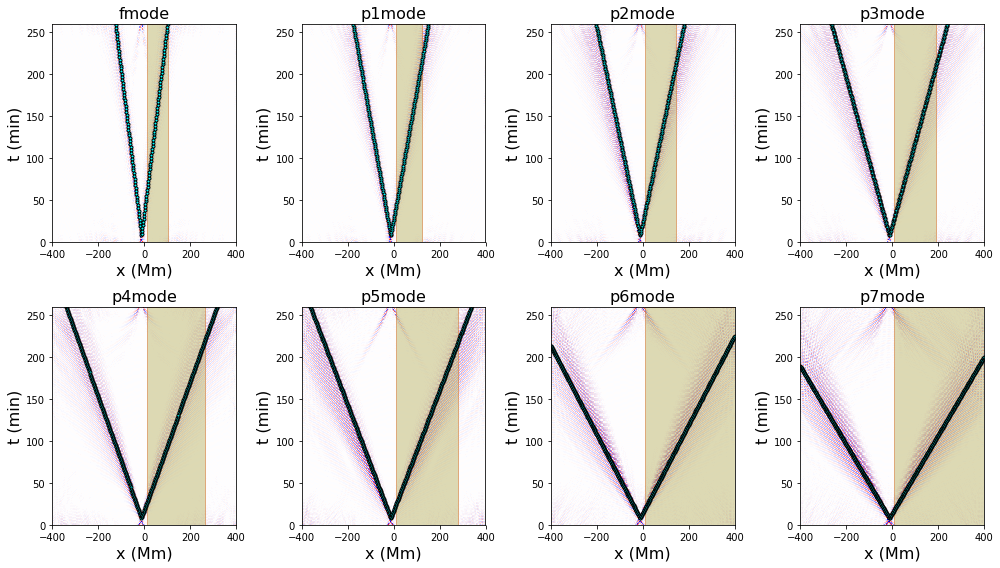

In [8]:
for ind,f in enumerate(ridge_filters):
    plt.subplot(2,4,ind+1)
    ridge_fn = getattr(modefilters,f)
    ridge = np.squeeze(ridge_fn(nt,dt_sec,nx,Lx)).T
    data_filtered = np.fft.ifft2(np.fft.fft2(data)*ridge).real
    vmax = abs(data_filtered).max()
    plt.pcolormesh(x,t/60,data_filtered,cmap="seismic",vmax=vmax,vmin=-vmax)
    plt.title(f.split("_")[0],fontsize=16)
    plt.xlabel("x (Mm)",fontsize=16)
    plt.ylabel("t (min)",fontsize=16)
    plt.xlim(x[0],x[-1])
    plt.ylim(t[0]/60,t[-1]/60)
    line = abs(x-src_loc)/wave_speeds[ind]+8
    plt.plot(x,line,ls="dashed",color="black",marker="o",markersize=3,markerfacecolor="cyan")
    if ind<len(params): plt.axvspan(*params[ind],facecolor="darkkhaki",edgecolor="chocolate",alpha=0.5)

plt.gcf().set_size_inches(14,8)
plt.tight_layout()

## Save params

In [9]:
np.savetxt(os.path.join(datadir,"tt_dist_ridges"),np.array(params).astype(int),fmt='%i')